## Problem 2

### Initialisising Colab drive

In [0]:
!pip install PyDrive

In [0]:
# http://pytorch.org/
!pip install torch

import torch
print(f"Your Pytorch version is {torch.__version__}.")

Your Pytorch version is 1.0.1.post2.


In [0]:
from google.colab import drive
drive.mount('/content/drive')
!ls "/content/drive/My Drive/Colab Notebooks/6135/Assignment_1.2"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 6135-Assignment_1.2.ipynb   best_CNN_3    'Copie de 6135-Assignment_1.2.ipynb'
 best_CNN_1		     best_MLP_2L
 best_CNN_2		     bests_Backup


### Librairies

In [0]:
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy
import random

%matplotlib inline

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from livelossplot import PlotLosses


print("Libraries ready")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cuda = device.type == 'cuda'
print(device, cuda)

Libraries ready
cuda:0 True


### Dataset

In [0]:
train_data = datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor()
                   ]))

test_data = datasets.MNIST('../data', train=False,
                   transform=transforms.Compose([
                       transforms.ToTensor()
                   ]))


In [0]:
batch_size = 128

valid_size = 15000

indices = list(range(len(train_data)))
random.shuffle(indices)

train_loader = DataLoader(
    train_data,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(indices[valid_size:]),
    num_workers=4,
    pin_memory=cuda
)

valid_loader = DataLoader(
    train_data,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(indices[:valid_size]),
    num_workers=4,
    pin_memory=cuda,
)

test_loader = DataLoader(
    test_data,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=cuda,
)

### Checking data

In [0]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Split: train
    Root Location: ../data
    Transforms (if any): Compose(
                             ToTensor()
                         )
    Target Transforms (if any): None

In [0]:
def showRandSample(dataset, n_row=5, n_col=5):
    nb_img = n_row * n_col
    
    sample_loader = DataLoader(
      dataset,
      batch_size=nb_img, 
      shuffle=True,
      num_workers=1,
      pin_memory=cuda)

    images, labels = next(iter(sample_loader))
    images = images.squeeze()
    
    fig = plt.figure(figsize=(n_row*2, n_col*2))

    for i in range(1, nb_img +1):
        img = images[i-1]    
        ax = fig.add_subplot(n_row, n_col, i)
        ax.set_title(str(labels[i-1].item()))
        plt.axis('off')
        plt.imshow(img,cmap='gray_r')
    plt.show()

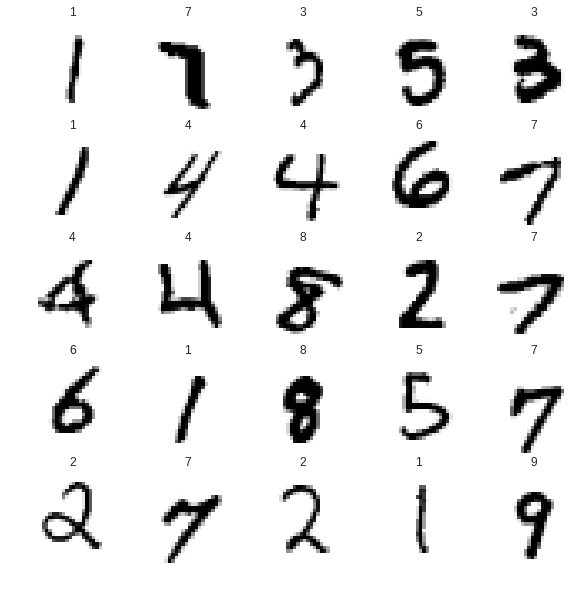

In [0]:
showRandSample(train_data) 

### MLP 
First as our compairason model we chose one of  MLP that reached 97.5 comming out of part 1, which is a simple model with 2 hidden layers of 512 and 768 neurons with Relu as the activation function. 

In [0]:
class MLP_2L(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        h1 = 512
        h2 = 768
        
        # Fully connected layer
        self.fc0 = nn.Linear(28*28, h1)
        self.fc1 = nn.Linear(h1, h2)
        self.fc2 = nn.Linear(h2, 10)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc0(x))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x


### CNN

To expose the effects of convolution on an image classification task, we build a simple CNN with convolution layers replacing a part of the MLP, in this case the first hidden layer.

Simply put : we replace the first hidden layer of the MLP with a convolution block.  
So, where we had :

[input]->[hidden 1]->[hidden 2]->[ouput]

we now have :

[input]->[convolution]->[hidden 2]->[ouput]


We tested 3 models CNN1, CNN2, CNN3 with a convolution block of 1 round, 2 rounds and 3 rounds of convolution.

Since our MLP's hidden layers have 512 and 768 neurons respectively and a total of 803k paramaters, we had few choices in designing those layers.   For CNN1 it is simply not possible to respect both conditions, we chose to respect the hidden layer; so the total number of parameters is half of the MLP.  CNN2 & CNN3 have not only the ~same amount of parameters but also the same hidden layer.

We effectively only **replace** the first hidden layer.  It also leads to a nicely balanced number of parameters compared to the MLP. (ie: the convotion part $\approx$ h1 of the MLP).   This way, the design patterns stay consistant troughout all of the models.


Here are the designs of the convolution block for the 3 models which all result in a layer of 512 neurons :

##### CNN1

{[  $32$ , $3\times3$ ]->[pooling $7$]}


##### CNN2

{[  $87$ , $3\times3$ ]->[pooling $3$]} -> {[  $512$ , $3\times3$ ]->[pooling $10$]}


##### CNN3

{[  $64$ , $3\times3$ ]->[pooling $2$]} -> {[  $77$ , $3\times3$ ]->[pooling $4$]} -> {[  $512$ , $3\times3$ ]->[pooling $4$]}



$87$ and $77$ might seem like strange numbers, they are chosen simply so that total number of parameters is as close to 803k as possible.
The last round of convolution for CNN2&3 must be of 512 filters with pooling down to 1 so that it connects to the hidden layer just like the MLP.  The filters are all $3\times3$ with stride of of $1$ so as to remain consistant, the adaptation factor for the size commes only from the padding in the first layer.  (by coincidence it is $1$, $2$, $3$ for CNN 1, 2 ,3 )  


In [0]:
class CNN_1(nn.Module):
    
    def __init__(self):
        super().__init__()
        # Conv block
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        
        # Fully connected layer
        self.fc1 = nn.Linear(32*4*4, 768)
        self.fc2 = nn.Linear(768, 10)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 7)
        
        x = x.view(x.size(0), -1) # flatten
        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x
      
class CNN_2(nn.Module):
    
    def __init__(self):
        super().__init__()
        # Conv block
        self.conv1 = nn.Conv2d(1, 87, 3, padding=2)
        self.conv2 = nn.Conv2d(87, 512, 3, padding=1)
        
        # Fully connected layer
        self.fc1 = nn.Linear(512*1*1, 768)
        self.fc2 = nn.Linear(768, 10)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 3)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 10)
        
        x = x.view(x.size(0), -1) # flatten
        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x     
      
class CNN_3(nn.Module):
    
    def __init__(self):
        super().__init__()
        # Conv block
        self.conv1 = nn.Conv2d(1, 64, 3, padding=3)
        self.conv2 = nn.Conv2d(64, 77, 3, padding=1)
        self.conv3 = nn.Conv2d(77, 512, 3, padding=1)
        
        # Fully connected layer
        self.fc1 = nn.Linear(512*1*1, 768)
        self.fc2 = nn.Linear(768, 10)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 4)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 4)
        
        x = x.view(x.size(0), -1) # flatten
        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x   


### Model verification and number of parameters :

In [0]:
#Number of parameters
from torchsummary import summary

model = CNN_1().to(device)

print("CNN_1 : ",sum(p.numel() for p in model.parameters() if p.requires_grad))
summary(model, (1, 28, 28))


model = CNN_2().to(device)

print("\nCNN_2 : ",sum(p.numel() for p in model.parameters() if p.requires_grad))
summary(model, (1, 28, 28))

model = CNN_3().to(device)

print("\nCNN_3 : ",sum(p.numel() for p in model.parameters() if p.requires_grad))
summary(model, (1, 28, 28))

model = MLP_2L().to(device)

print("\nMLP_2L : ",sum(p.numel() for p in model.parameters() if p.requires_grad))
summary(model, (1, 28, 28))

CNN_1 :  401994
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
            Linear-2                  [-1, 768]         393,984
            Linear-3                   [-1, 10]           7,690
Total params: 401,994
Trainable params: 401,994
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.20
Params size (MB): 1.53
Estimated Total Size (MB): 1.73
----------------------------------------------------------------

CNN_2 :  803952
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 87, 30, 30]             870
            Conv2d-2          [-1, 512, 10, 10]         401,408
            Linear-3                  [-1, 768]         393,984
        

In [0]:
loss_fn = nn.CrossEntropyLoss()
test_loss_fn = nn.CrossEntropyLoss(reduction='sum')

#Results directory
savedir = 'results'
if not os.path.exists(savedir):
    os.makedirs(savedir)


## Saved states are ignored for this expirement

#checkpoint = torch.load('/content/drive/My Drive/Colab Notebooks//6135/Assignment_1.2')
#model.load_state_dict(checkpoint['state_dict'])

In [0]:
def test(model, loader, dset = 'validation'):
    model.eval()
    
    test_loss = 0
    correct = 0
    test_size = 0
    with torch.no_grad():
        for inputs, target in loader:
            inputs = inputs.to(device,dtype=torch.float) 
            target = target.to(device, dtype=torch.long)
            
            output = model(inputs)
            test_size += len(inputs)
            test_loss += test_loss_fn(output, target).item() 
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= test_size
    accuracy = correct / test_size
    if dset == "validation":
      print('Validation error: {}/{} ({:.2f}%)\n'.format(
          (test_size-correct), test_size,
          100. * (1-accuracy)))
      print('Validation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
          test_loss, correct, test_size,
          100. * accuracy))
    if dset == "train":
      print('\nTraining error: {}/{} ({:.2f}%)'.format(
          (test_size-correct), test_size,
          100. * (1-accuracy)))
    if dset == "test":
      print('\n          Test set Accuracy: {}/{} ({:.2f}%)\n'.format(
          correct, test_size,
          100. * accuracy))
      
      
    
    return test_loss, accuracy

In [0]:
def train(model,loader, optimizer, epoch, scheduler):
    model.train()
    
    for batch_idx, (inputs, target) in enumerate(loader):
        inputs = inputs.to(device, dtype=torch.float)
        target = target.to(device, dtype=torch.long)
        
        optimizer.zero_grad()
        output = model(inputs)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        
        if batch_idx % 100 == 0:  
            print(model.__class__.__name__,' Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch +1, batch_idx * len(inputs), len(loader) *len(inputs) ,
                100. * batch_idx / len(loader), loss.item()))
    
    scheduler.step()
    return test(model, loader, dset = 'train')

### Running the experiment

The experiment being non-determinist, depending on weight initialisation and the draw of the training set, 
we run the experiment multiple times and take the average results for each correspoding epochs, reseting all weights and sets for each run.

Here : 10 runs of 10 epochs.

In [0]:
runs = 10
epochs = 10

In [0]:
import pickle

def weight_reset(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()


def MultipleRun(runs,epochs,model):
  liveloss = PlotLosses()
  model = model.to(device)
  name =  model.__class__.__name__

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=0.1)
  exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=1.0)


  results = {'name':name, 'loss': [0]*epochs, 'accuracy':[0]*epochs}
  savefile = os.path.join(savedir, results['name']+'.pkl' )

  best_net = '/content/drive/My Drive/Colab Notebooks//6135/Assignment_1.2/best_' + name
  
  for run in range(runs):
      print("\n","  --  Run : ", run+1)
      since = time.time()
      best_accuracy = 0
      
      #Reseting all weights for new run
      model.apply(weight_reset)

      log_error = {'train_error':[0]*epochs,'valid_error':[0]*epochs}
      
      for epoch in range(epochs):
          train_loss, train_acc = train(model, train_loader, optimizer, epoch,exp_lr_scheduler)
          loss, acc = test(model, valid_loader, dset = 'validation')

          if acc > best_accuracy:
            best_accuracy = acc
                        
            #Saving best model parameters
            torch.save({
                'epoch_based0': epoch,
                'state_dict': model.state_dict(),
                'accuracy': acc,
                'loss' : loss,
                'optimizer' : optimizer.state_dict(),
            }, best_net)

            print('new accuracy parameters saved {}'.format(best_accuracy))

          #Updating average results
          results['loss'][epoch] += loss/runs
          results['accuracy'][epoch] += acc/runs
          log_error['train_error'][epoch] += (1-train_acc)*100
          log_error['valid_error'][epoch] += (1-acc)*100
          


      _, _ = test(model, test_loader, dset = "test")    
      time_elapsed = time.time() - since
      print('Training complete in {:.0f}m {:.0f}s'.format(
              time_elapsed // 60, time_elapsed % 60))
      
      ##plotting errors
      fig, ax1 = plt.subplots(figsize=(10, 4))
      ax1.plot(log_error['train_error'], label = "train")
      ax1.plot(log_error['valid_error'], label = "validation")
      ax1.set_ylabel('error')
      ax1.set_xlabel('epochs')
      plt.legend()
      plt.show()
    
  with open(savefile, 'wb') as fout:
    pickle.dump(results, fout)
    
 

### Running CNN1


   --  Run :  1
CNN_1  Epoch: 1 [0/45056 (0%)]	Loss: 2.294302
CNN_1  Epoch: 1 [12800/45056 (28%)]	Loss: 0.848484
CNN_1  Epoch: 1 [25600/45056 (57%)]	Loss: 0.412616
CNN_1  Epoch: 1 [38400/45056 (85%)]	Loss: 0.264937

Training error: 4098/45000 (9.11%)
Validation error: 1364/15000 (9.09%)

Validation set: Average loss: 0.3017, Accuracy: 13636/15000 (90.91%)

new accuracy parameters saved 0.9090666666666667
CNN_1  Epoch: 2 [0/45056 (0%)]	Loss: 0.218321
CNN_1  Epoch: 2 [12800/45056 (28%)]	Loss: 0.237038
CNN_1  Epoch: 2 [25600/45056 (57%)]	Loss: 0.346456
CNN_1  Epoch: 2 [38400/45056 (85%)]	Loss: 0.156660

Training error: 2511/45000 (5.58%)
Validation error: 845/15000 (5.63%)

Validation set: Average loss: 0.1861, Accuracy: 14155/15000 (94.37%)

new accuracy parameters saved 0.9436666666666667
CNN_1  Epoch: 3 [0/45056 (0%)]	Loss: 0.194540
CNN_1  Epoch: 3 [12800/45056 (28%)]	Loss: 0.131922
CNN_1  Epoch: 3 [25600/45056 (57%)]	Loss: 0.240335
CNN_1  Epoch: 3 [38400/45056 (85%)]	Loss: 0.184385



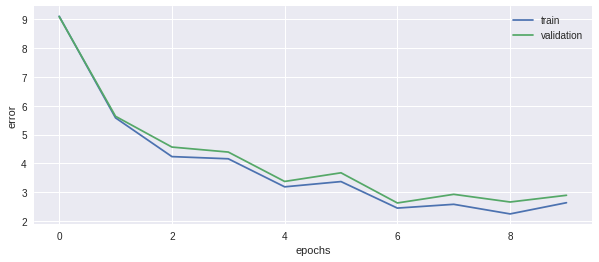


   --  Run :  2
CNN_1  Epoch: 1 [0/45056 (0%)]	Loss: 2.318113
CNN_1  Epoch: 1 [12800/45056 (28%)]	Loss: 0.920720
CNN_1  Epoch: 1 [25600/45056 (57%)]	Loss: 0.556584
CNN_1  Epoch: 1 [38400/45056 (85%)]	Loss: 0.408945

Training error: 4105/45000 (9.12%)
Validation error: 1412/15000 (9.41%)

Validation set: Average loss: 0.3095, Accuracy: 13588/15000 (90.59%)

new accuracy parameters saved 0.9058666666666667
CNN_1  Epoch: 2 [0/45056 (0%)]	Loss: 0.331208
CNN_1  Epoch: 2 [12800/45056 (28%)]	Loss: 0.309497
CNN_1  Epoch: 2 [25600/45056 (57%)]	Loss: 0.193268
CNN_1  Epoch: 2 [38400/45056 (85%)]	Loss: 0.160204

Training error: 2435/45000 (5.41%)
Validation error: 846/15000 (5.64%)

Validation set: Average loss: 0.1791, Accuracy: 14154/15000 (94.36%)

new accuracy parameters saved 0.9436
CNN_1  Epoch: 3 [0/45056 (0%)]	Loss: 0.120274
CNN_1  Epoch: 3 [12800/45056 (28%)]	Loss: 0.093564
CNN_1  Epoch: 3 [25600/45056 (57%)]	Loss: 0.132175
CNN_1  Epoch: 3 [38400/45056 (85%)]	Loss: 0.081614

Training err

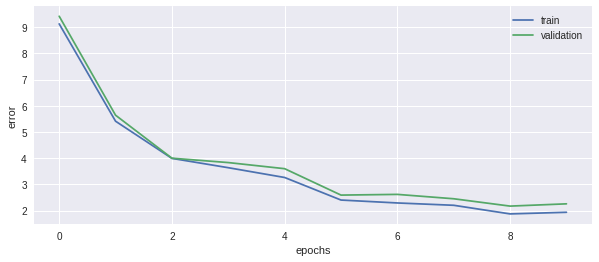


   --  Run :  3
CNN_1  Epoch: 1 [0/45056 (0%)]	Loss: 2.316419
CNN_1  Epoch: 1 [12800/45056 (28%)]	Loss: 0.958262
CNN_1  Epoch: 1 [25600/45056 (57%)]	Loss: 0.687422
CNN_1  Epoch: 1 [38400/45056 (85%)]	Loss: 0.376946

Training error: 4487/45000 (9.97%)
Validation error: 1476/15000 (9.84%)

Validation set: Average loss: 0.3359, Accuracy: 13524/15000 (90.16%)

new accuracy parameters saved 0.9016
CNN_1  Epoch: 2 [0/45056 (0%)]	Loss: 0.433110
CNN_1  Epoch: 2 [12800/45056 (28%)]	Loss: 0.176827
CNN_1  Epoch: 2 [25600/45056 (57%)]	Loss: 0.161908
CNN_1  Epoch: 2 [38400/45056 (85%)]	Loss: 0.220440

Training error: 2947/45000 (6.55%)
Validation error: 1005/15000 (6.70%)

Validation set: Average loss: 0.2115, Accuracy: 13995/15000 (93.30%)

new accuracy parameters saved 0.933
CNN_1  Epoch: 3 [0/45056 (0%)]	Loss: 0.203503
CNN_1  Epoch: 3 [12800/45056 (28%)]	Loss: 0.174925
CNN_1  Epoch: 3 [25600/45056 (57%)]	Loss: 0.126889
CNN_1  Epoch: 3 [38400/45056 (85%)]	Loss: 0.161858

Training error: 1858/450

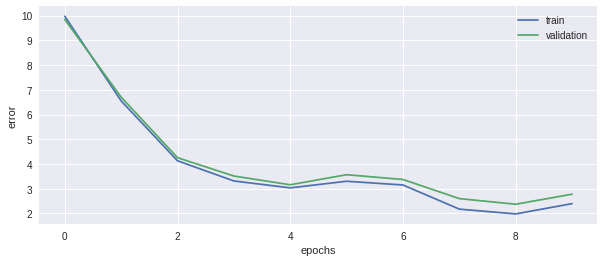


   --  Run :  4
CNN_1  Epoch: 1 [0/45056 (0%)]	Loss: 2.292669
CNN_1  Epoch: 1 [12800/45056 (28%)]	Loss: 0.979748
CNN_1  Epoch: 1 [25600/45056 (57%)]	Loss: 0.545199
CNN_1  Epoch: 1 [38400/45056 (85%)]	Loss: 0.280432

Training error: 4750/45000 (10.56%)
Validation error: 1523/15000 (10.15%)

Validation set: Average loss: 0.3231, Accuracy: 13477/15000 (89.85%)

new accuracy parameters saved 0.8984666666666666
CNN_1  Epoch: 2 [0/45056 (0%)]	Loss: 0.325897
CNN_1  Epoch: 2 [12800/45056 (28%)]	Loss: 0.199733
CNN_1  Epoch: 2 [25600/45056 (57%)]	Loss: 0.243215
CNN_1  Epoch: 2 [38400/45056 (85%)]	Loss: 0.229953

Training error: 2153/45000 (4.78%)
Validation error: 731/15000 (4.87%)

Validation set: Average loss: 0.1608, Accuracy: 14269/15000 (95.13%)

new accuracy parameters saved 0.9512666666666667
CNN_1  Epoch: 3 [0/45056 (0%)]	Loss: 0.203382
CNN_1  Epoch: 3 [12800/45056 (28%)]	Loss: 0.138748
CNN_1  Epoch: 3 [25600/45056 (57%)]	Loss: 0.071723
CNN_1  Epoch: 3 [38400/45056 (85%)]	Loss: 0.102523

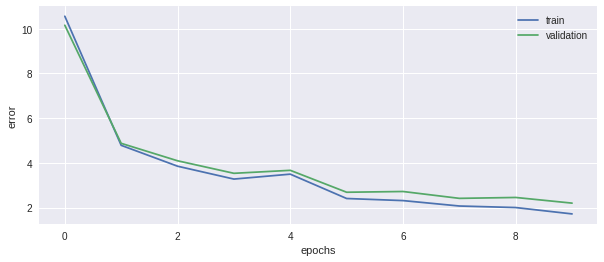


   --  Run :  5
CNN_1  Epoch: 1 [0/45056 (0%)]	Loss: 2.309675
CNN_1  Epoch: 1 [12800/45056 (28%)]	Loss: 0.959807
CNN_1  Epoch: 1 [25600/45056 (57%)]	Loss: 0.611928
CNN_1  Epoch: 1 [38400/45056 (85%)]	Loss: 0.303887

Training error: 4365/45000 (9.70%)
Validation error: 1443/15000 (9.62%)

Validation set: Average loss: 0.3156, Accuracy: 13557/15000 (90.38%)

new accuracy parameters saved 0.9038
CNN_1  Epoch: 2 [0/45056 (0%)]	Loss: 0.243743
CNN_1  Epoch: 2 [12800/45056 (28%)]	Loss: 0.295415
CNN_1  Epoch: 2 [25600/45056 (57%)]	Loss: 0.218267
CNN_1  Epoch: 2 [38400/45056 (85%)]	Loss: 0.179365

Training error: 2177/45000 (4.84%)
Validation error: 748/15000 (4.99%)

Validation set: Average loss: 0.1682, Accuracy: 14252/15000 (95.01%)

new accuracy parameters saved 0.9501333333333334
CNN_1  Epoch: 3 [0/45056 (0%)]	Loss: 0.225407
CNN_1  Epoch: 3 [12800/45056 (28%)]	Loss: 0.114447
CNN_1  Epoch: 3 [25600/45056 (57%)]	Loss: 0.248137
CNN_1  Epoch: 3 [38400/45056 (85%)]	Loss: 0.130773

Training err

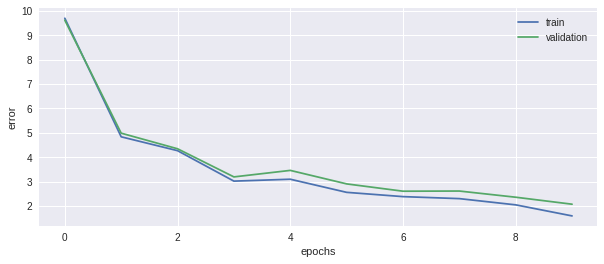


   --  Run :  6
CNN_1  Epoch: 1 [0/45056 (0%)]	Loss: 2.316000
CNN_1  Epoch: 1 [12800/45056 (28%)]	Loss: 0.841055
CNN_1  Epoch: 1 [25600/45056 (57%)]	Loss: 0.732064
CNN_1  Epoch: 1 [38400/45056 (85%)]	Loss: 0.355700

Training error: 3579/45000 (7.95%)
Validation error: 1189/15000 (7.93%)

Validation set: Average loss: 0.2641, Accuracy: 13811/15000 (92.07%)

new accuracy parameters saved 0.9207333333333333
CNN_1  Epoch: 2 [0/45056 (0%)]	Loss: 0.276003
CNN_1  Epoch: 2 [12800/45056 (28%)]	Loss: 0.232557
CNN_1  Epoch: 2 [25600/45056 (57%)]	Loss: 0.203282
CNN_1  Epoch: 2 [38400/45056 (85%)]	Loss: 0.201192

Training error: 2194/45000 (4.88%)
Validation error: 765/15000 (5.10%)

Validation set: Average loss: 0.1638, Accuracy: 14235/15000 (94.90%)

new accuracy parameters saved 0.949
CNN_1  Epoch: 3 [0/45056 (0%)]	Loss: 0.187791
CNN_1  Epoch: 3 [12800/45056 (28%)]	Loss: 0.146446
CNN_1  Epoch: 3 [25600/45056 (57%)]	Loss: 0.091031
CNN_1  Epoch: 3 [38400/45056 (85%)]	Loss: 0.133096

Training erro

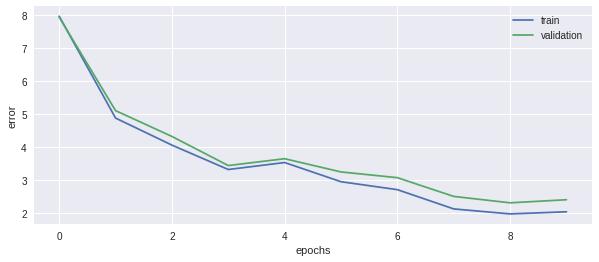


   --  Run :  7
CNN_1  Epoch: 1 [0/45056 (0%)]	Loss: 2.316194
CNN_1  Epoch: 1 [12800/45056 (28%)]	Loss: 0.958799
CNN_1  Epoch: 1 [25600/45056 (57%)]	Loss: 0.460769
CNN_1  Epoch: 1 [38400/45056 (85%)]	Loss: 0.264321

Training error: 4288/45000 (9.53%)
Validation error: 1423/15000 (9.49%)

Validation set: Average loss: 0.3281, Accuracy: 13577/15000 (90.51%)

new accuracy parameters saved 0.9051333333333333
CNN_1  Epoch: 2 [0/45056 (0%)]	Loss: 0.356356
CNN_1  Epoch: 2 [12800/45056 (28%)]	Loss: 0.170558
CNN_1  Epoch: 2 [25600/45056 (57%)]	Loss: 0.153327
CNN_1  Epoch: 2 [38400/45056 (85%)]	Loss: 0.107063

Training error: 2339/45000 (5.20%)
Validation error: 778/15000 (5.19%)

Validation set: Average loss: 0.1672, Accuracy: 14222/15000 (94.81%)

new accuracy parameters saved 0.9481333333333334
CNN_1  Epoch: 3 [0/45056 (0%)]	Loss: 0.115293
CNN_1  Epoch: 3 [12800/45056 (28%)]	Loss: 0.238399
CNN_1  Epoch: 3 [25600/45056 (57%)]	Loss: 0.216162
CNN_1  Epoch: 3 [38400/45056 (85%)]	Loss: 0.127914



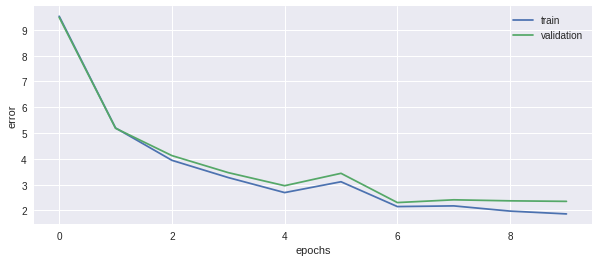


   --  Run :  8
CNN_1  Epoch: 1 [0/45056 (0%)]	Loss: 2.308311
CNN_1  Epoch: 1 [12800/45056 (28%)]	Loss: 0.942928
CNN_1  Epoch: 1 [25600/45056 (57%)]	Loss: 0.469448
CNN_1  Epoch: 1 [38400/45056 (85%)]	Loss: 0.515468

Training error: 4293/45000 (9.54%)
Validation error: 1396/15000 (9.31%)

Validation set: Average loss: 0.2941, Accuracy: 13604/15000 (90.69%)

new accuracy parameters saved 0.9069333333333334
CNN_1  Epoch: 2 [0/45056 (0%)]	Loss: 0.295952
CNN_1  Epoch: 2 [12800/45056 (28%)]	Loss: 0.203945
CNN_1  Epoch: 2 [25600/45056 (57%)]	Loss: 0.191622
CNN_1  Epoch: 2 [38400/45056 (85%)]	Loss: 0.169886

Training error: 2447/45000 (5.44%)
Validation error: 836/15000 (5.57%)

Validation set: Average loss: 0.1849, Accuracy: 14164/15000 (94.43%)

new accuracy parameters saved 0.9442666666666667
CNN_1  Epoch: 3 [0/45056 (0%)]	Loss: 0.148712
CNN_1  Epoch: 3 [12800/45056 (28%)]	Loss: 0.251501
CNN_1  Epoch: 3 [25600/45056 (57%)]	Loss: 0.203044
CNN_1  Epoch: 3 [38400/45056 (85%)]	Loss: 0.086132



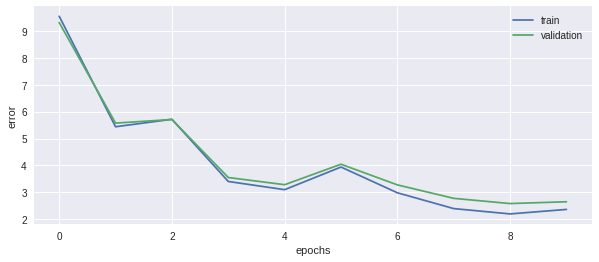


   --  Run :  9
CNN_1  Epoch: 1 [0/45056 (0%)]	Loss: 2.300168
CNN_1  Epoch: 1 [12800/45056 (28%)]	Loss: 0.973672
CNN_1  Epoch: 1 [25600/45056 (57%)]	Loss: 0.500846
CNN_1  Epoch: 1 [38400/45056 (85%)]	Loss: 0.526579

Training error: 3997/45000 (8.88%)
Validation error: 1301/15000 (8.67%)

Validation set: Average loss: 0.2983, Accuracy: 13699/15000 (91.33%)

new accuracy parameters saved 0.9132666666666667
CNN_1  Epoch: 2 [0/45056 (0%)]	Loss: 0.269500
CNN_1  Epoch: 2 [12800/45056 (28%)]	Loss: 0.194095
CNN_1  Epoch: 2 [25600/45056 (57%)]	Loss: 0.225680
CNN_1  Epoch: 2 [38400/45056 (85%)]	Loss: 0.190236

Training error: 2631/45000 (5.85%)
Validation error: 877/15000 (5.85%)

Validation set: Average loss: 0.1861, Accuracy: 14123/15000 (94.15%)

new accuracy parameters saved 0.9415333333333333
CNN_1  Epoch: 3 [0/45056 (0%)]	Loss: 0.216895
CNN_1  Epoch: 3 [12800/45056 (28%)]	Loss: 0.186636
CNN_1  Epoch: 3 [25600/45056 (57%)]	Loss: 0.197445
CNN_1  Epoch: 3 [38400/45056 (85%)]	Loss: 0.136426



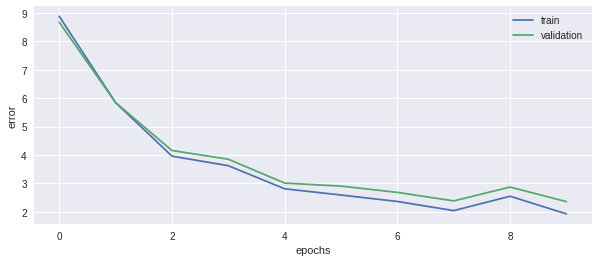


   --  Run :  10
CNN_1  Epoch: 1 [0/45056 (0%)]	Loss: 2.328891
CNN_1  Epoch: 1 [12800/45056 (28%)]	Loss: 1.028992
CNN_1  Epoch: 1 [25600/45056 (57%)]	Loss: 0.460527
CNN_1  Epoch: 1 [38400/45056 (85%)]	Loss: 0.212886

Training error: 3306/45000 (7.35%)
Validation error: 1088/15000 (7.25%)

Validation set: Average loss: 0.2599, Accuracy: 13912/15000 (92.75%)

new accuracy parameters saved 0.9274666666666667
CNN_1  Epoch: 2 [0/45056 (0%)]	Loss: 0.362789
CNN_1  Epoch: 2 [12800/45056 (28%)]	Loss: 0.191364
CNN_1  Epoch: 2 [25600/45056 (57%)]	Loss: 0.137065
CNN_1  Epoch: 2 [38400/45056 (85%)]	Loss: 0.150098

Training error: 2391/45000 (5.31%)
Validation error: 811/15000 (5.41%)

Validation set: Average loss: 0.1736, Accuracy: 14189/15000 (94.59%)

new accuracy parameters saved 0.9459333333333333
CNN_1  Epoch: 3 [0/45056 (0%)]	Loss: 0.166869
CNN_1  Epoch: 3 [12800/45056 (28%)]	Loss: 0.252910
CNN_1  Epoch: 3 [25600/45056 (57%)]	Loss: 0.087359
CNN_1  Epoch: 3 [38400/45056 (85%)]	Loss: 0.133314


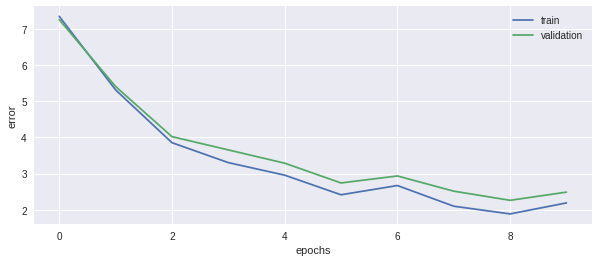

In [0]:
MultipleRun(runs,epochs,CNN_1())

### Running CNN2


   --  Run :  1
CNN_2  Epoch: 1 [0/45056 (0%)]	Loss: 2.300169
CNN_2  Epoch: 1 [12800/45056 (28%)]	Loss: 2.705853
CNN_2  Epoch: 1 [25600/45056 (57%)]	Loss: 0.852410
CNN_2  Epoch: 1 [38400/45056 (85%)]	Loss: 0.341907

Training error: 4585/45000 (10.19%)
Validation error: 1513/15000 (10.09%)

Validation set: Average loss: 0.3348, Accuracy: 13487/15000 (89.91%)

new accuracy parameters saved 0.8991333333333333
CNN_2  Epoch: 2 [0/45056 (0%)]	Loss: 0.388798
CNN_2  Epoch: 2 [12800/45056 (28%)]	Loss: 0.231816
CNN_2  Epoch: 2 [25600/45056 (57%)]	Loss: 0.199513
CNN_2  Epoch: 2 [38400/45056 (85%)]	Loss: 0.182626

Training error: 1964/45000 (4.36%)
Validation error: 685/15000 (4.57%)

Validation set: Average loss: 0.1518, Accuracy: 14315/15000 (95.43%)

new accuracy parameters saved 0.9543333333333334
CNN_2  Epoch: 3 [0/45056 (0%)]	Loss: 0.062431
CNN_2  Epoch: 3 [12800/45056 (28%)]	Loss: 0.122114
CNN_2  Epoch: 3 [25600/45056 (57%)]	Loss: 0.088003
CNN_2  Epoch: 3 [38400/45056 (85%)]	Loss: 0.119481

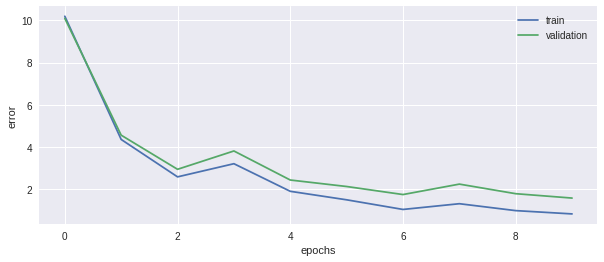


   --  Run :  2
CNN_2  Epoch: 1 [0/45056 (0%)]	Loss: 2.303232
CNN_2  Epoch: 1 [12800/45056 (28%)]	Loss: 1.784796
CNN_2  Epoch: 1 [25600/45056 (57%)]	Loss: 1.093404
CNN_2  Epoch: 1 [38400/45056 (85%)]	Loss: 0.475519

Training error: 8704/45000 (19.34%)
Validation error: 2970/15000 (19.80%)

Validation set: Average loss: 0.6183, Accuracy: 12030/15000 (80.20%)

new accuracy parameters saved 0.802
CNN_2  Epoch: 2 [0/45056 (0%)]	Loss: 0.481141
CNN_2  Epoch: 2 [12800/45056 (28%)]	Loss: 0.179987
CNN_2  Epoch: 2 [25600/45056 (57%)]	Loss: 0.158566
CNN_2  Epoch: 2 [38400/45056 (85%)]	Loss: 0.153518

Training error: 2095/45000 (4.66%)
Validation error: 738/15000 (4.92%)

Validation set: Average loss: 0.1631, Accuracy: 14262/15000 (95.08%)

new accuracy parameters saved 0.9508
CNN_2  Epoch: 3 [0/45056 (0%)]	Loss: 0.203236
CNN_2  Epoch: 3 [12800/45056 (28%)]	Loss: 0.202663
CNN_2  Epoch: 3 [25600/45056 (57%)]	Loss: 0.107517
CNN_2  Epoch: 3 [38400/45056 (85%)]	Loss: 0.103364

Training error: 2263/45

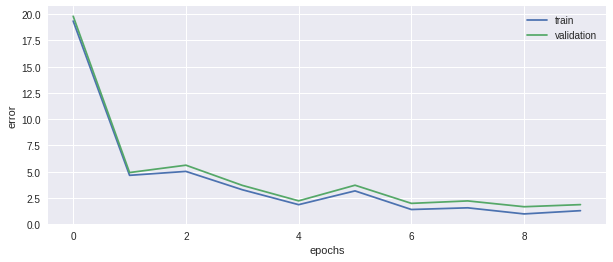


   --  Run :  3
CNN_2  Epoch: 1 [0/45056 (0%)]	Loss: 2.295536
CNN_2  Epoch: 1 [12800/45056 (28%)]	Loss: 2.276965
CNN_2  Epoch: 1 [25600/45056 (57%)]	Loss: 0.915377
CNN_2  Epoch: 1 [38400/45056 (85%)]	Loss: 0.727101

Training error: 3753/45000 (8.34%)
Validation error: 1251/15000 (8.34%)

Validation set: Average loss: 0.3053, Accuracy: 13749/15000 (91.66%)

new accuracy parameters saved 0.9166
CNN_2  Epoch: 2 [0/45056 (0%)]	Loss: 0.261694
CNN_2  Epoch: 2 [12800/45056 (28%)]	Loss: 0.219214
CNN_2  Epoch: 2 [25600/45056 (57%)]	Loss: 0.153871
CNN_2  Epoch: 2 [38400/45056 (85%)]	Loss: 0.144563

Training error: 1747/45000 (3.88%)
Validation error: 647/15000 (4.31%)

Validation set: Average loss: 0.1382, Accuracy: 14353/15000 (95.69%)

new accuracy parameters saved 0.9568666666666666
CNN_2  Epoch: 3 [0/45056 (0%)]	Loss: 0.144987
CNN_2  Epoch: 3 [12800/45056 (28%)]	Loss: 0.097303
CNN_2  Epoch: 3 [25600/45056 (57%)]	Loss: 0.073663
CNN_2  Epoch: 3 [38400/45056 (85%)]	Loss: 0.103181

Training err

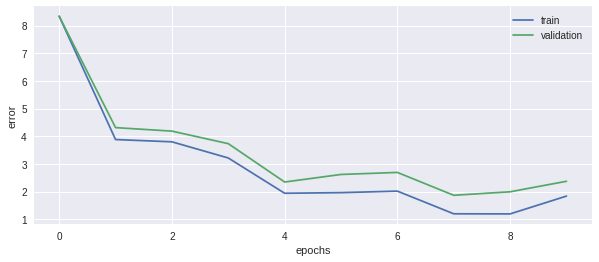


   --  Run :  4
CNN_2  Epoch: 1 [0/45056 (0%)]	Loss: 2.300878
CNN_2  Epoch: 1 [12800/45056 (28%)]	Loss: 2.013856
CNN_2  Epoch: 1 [25600/45056 (57%)]	Loss: 1.696342
CNN_2  Epoch: 1 [38400/45056 (85%)]	Loss: 0.300034

Training error: 4030/45000 (8.96%)
Validation error: 1364/15000 (9.09%)

Validation set: Average loss: 0.3192, Accuracy: 13636/15000 (90.91%)

new accuracy parameters saved 0.9090666666666667
CNN_2  Epoch: 2 [0/45056 (0%)]	Loss: 0.300795
CNN_2  Epoch: 2 [12800/45056 (28%)]	Loss: 0.129485
CNN_2  Epoch: 2 [25600/45056 (57%)]	Loss: 0.191263
CNN_2  Epoch: 2 [38400/45056 (85%)]	Loss: 0.202798

Training error: 3009/45000 (6.69%)
Validation error: 1063/15000 (7.09%)

Validation set: Average loss: 0.2122, Accuracy: 13937/15000 (92.91%)

new accuracy parameters saved 0.9291333333333334
CNN_2  Epoch: 3 [0/45056 (0%)]	Loss: 0.147159
CNN_2  Epoch: 3 [12800/45056 (28%)]	Loss: 0.121232
CNN_2  Epoch: 3 [25600/45056 (57%)]	Loss: 0.042104
CNN_2  Epoch: 3 [38400/45056 (85%)]	Loss: 0.110015


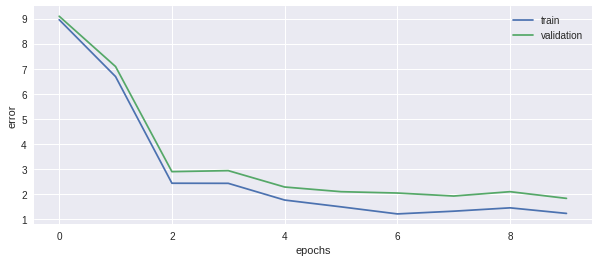


   --  Run :  5
CNN_2  Epoch: 1 [0/45056 (0%)]	Loss: 2.297583
CNN_2  Epoch: 1 [12800/45056 (28%)]	Loss: 1.937051
CNN_2  Epoch: 1 [25600/45056 (57%)]	Loss: 1.010102
CNN_2  Epoch: 1 [38400/45056 (85%)]	Loss: 0.431509

Training error: 7141/45000 (15.87%)
Validation error: 2406/15000 (16.04%)

Validation set: Average loss: 0.4525, Accuracy: 12594/15000 (83.96%)

new accuracy parameters saved 0.8396
CNN_2  Epoch: 2 [0/45056 (0%)]	Loss: 0.542104
CNN_2  Epoch: 2 [12800/45056 (28%)]	Loss: 0.221248
CNN_2  Epoch: 2 [25600/45056 (57%)]	Loss: 0.133420
CNN_2  Epoch: 2 [38400/45056 (85%)]	Loss: 0.170554

Training error: 1940/45000 (4.31%)
Validation error: 685/15000 (4.57%)

Validation set: Average loss: 0.1492, Accuracy: 14315/15000 (95.43%)

new accuracy parameters saved 0.9543333333333334
CNN_2  Epoch: 3 [0/45056 (0%)]	Loss: 0.154144
CNN_2  Epoch: 3 [12800/45056 (28%)]	Loss: 0.103339
CNN_2  Epoch: 3 [25600/45056 (57%)]	Loss: 0.093901
CNN_2  Epoch: 3 [38400/45056 (85%)]	Loss: 0.090443

Training e

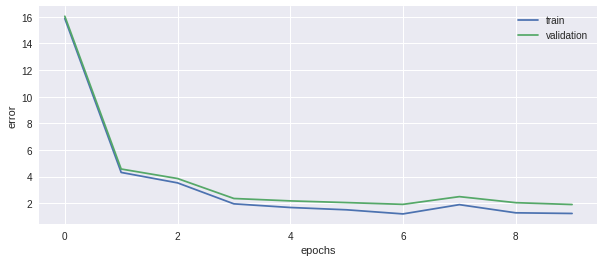


   --  Run :  6
CNN_2  Epoch: 1 [0/45056 (0%)]	Loss: 2.306856
CNN_2  Epoch: 1 [12800/45056 (28%)]	Loss: 1.785222
CNN_2  Epoch: 1 [25600/45056 (57%)]	Loss: 1.153139
CNN_2  Epoch: 1 [38400/45056 (85%)]	Loss: 0.725509

Training error: 4964/45000 (11.03%)
Validation error: 1646/15000 (10.97%)

Validation set: Average loss: 0.3740, Accuracy: 13354/15000 (89.03%)

new accuracy parameters saved 0.8902666666666667
CNN_2  Epoch: 2 [0/45056 (0%)]	Loss: 0.291024
CNN_2  Epoch: 2 [12800/45056 (28%)]	Loss: 0.264505
CNN_2  Epoch: 2 [25600/45056 (57%)]	Loss: 0.200179
CNN_2  Epoch: 2 [38400/45056 (85%)]	Loss: 0.174653

Training error: 1690/45000 (3.76%)
Validation error: 621/15000 (4.14%)

Validation set: Average loss: 0.1614, Accuracy: 14379/15000 (95.86%)

new accuracy parameters saved 0.9586
CNN_2  Epoch: 3 [0/45056 (0%)]	Loss: 0.179415
CNN_2  Epoch: 3 [12800/45056 (28%)]	Loss: 0.045238
CNN_2  Epoch: 3 [25600/45056 (57%)]	Loss: 0.084686
CNN_2  Epoch: 3 [38400/45056 (85%)]	Loss: 0.082546

Training e

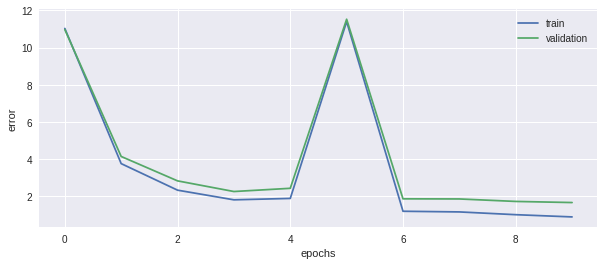


   --  Run :  7
CNN_2  Epoch: 1 [0/45056 (0%)]	Loss: 2.310311
CNN_2  Epoch: 1 [12800/45056 (28%)]	Loss: 1.934602
CNN_2  Epoch: 1 [25600/45056 (57%)]	Loss: 1.060061
CNN_2  Epoch: 1 [38400/45056 (85%)]	Loss: 0.529126

Training error: 4068/45000 (9.04%)
Validation error: 1359/15000 (9.06%)

Validation set: Average loss: 0.3714, Accuracy: 13641/15000 (90.94%)

new accuracy parameters saved 0.9094
CNN_2  Epoch: 2 [0/45056 (0%)]	Loss: 0.359511
CNN_2  Epoch: 2 [12800/45056 (28%)]	Loss: 0.218438
CNN_2  Epoch: 2 [25600/45056 (57%)]	Loss: 0.123825
CNN_2  Epoch: 2 [38400/45056 (85%)]	Loss: 0.125035

Training error: 1559/45000 (3.46%)
Validation error: 587/15000 (3.91%)

Validation set: Average loss: 0.1241, Accuracy: 14413/15000 (96.09%)

new accuracy parameters saved 0.9608666666666666
CNN_2  Epoch: 3 [0/45056 (0%)]	Loss: 0.123706
CNN_2  Epoch: 3 [12800/45056 (28%)]	Loss: 0.120808
CNN_2  Epoch: 3 [25600/45056 (57%)]	Loss: 0.166965
CNN_2  Epoch: 3 [38400/45056 (85%)]	Loss: 0.163382

Training err

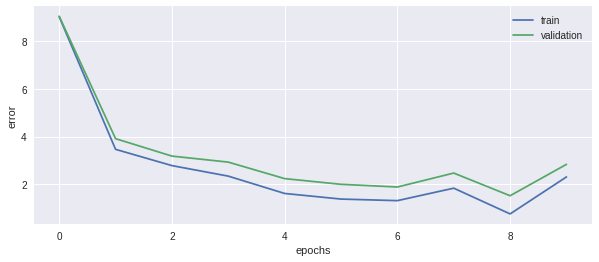


   --  Run :  8
CNN_2  Epoch: 1 [0/45056 (0%)]	Loss: 2.303851
CNN_2  Epoch: 1 [12800/45056 (28%)]	Loss: 1.963926
CNN_2  Epoch: 1 [25600/45056 (57%)]	Loss: 1.382357
CNN_2  Epoch: 1 [38400/45056 (85%)]	Loss: 0.637129

Training error: 13412/45000 (29.80%)
Validation error: 4448/15000 (29.65%)

Validation set: Average loss: 1.1718, Accuracy: 10552/15000 (70.35%)

new accuracy parameters saved 0.7034666666666667
CNN_2  Epoch: 2 [0/45056 (0%)]	Loss: 1.106375
CNN_2  Epoch: 2 [12800/45056 (28%)]	Loss: 0.174492
CNN_2  Epoch: 2 [25600/45056 (57%)]	Loss: 0.121523
CNN_2  Epoch: 2 [38400/45056 (85%)]	Loss: 0.145858

Training error: 1843/45000 (4.10%)
Validation error: 682/15000 (4.55%)

Validation set: Average loss: 0.1451, Accuracy: 14318/15000 (95.45%)

new accuracy parameters saved 0.9545333333333333
CNN_2  Epoch: 3 [0/45056 (0%)]	Loss: 0.126206
CNN_2  Epoch: 3 [12800/45056 (28%)]	Loss: 0.204136
CNN_2  Epoch: 3 [25600/45056 (57%)]	Loss: 0.071151
CNN_2  Epoch: 3 [38400/45056 (85%)]	Loss: 0.06568

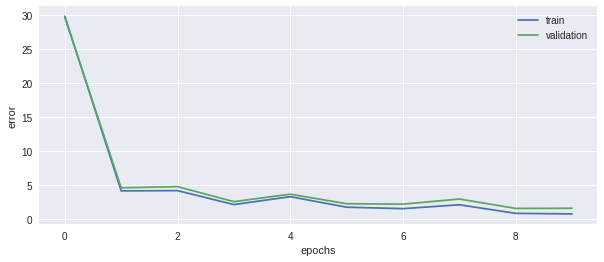


   --  Run :  9
CNN_2  Epoch: 1 [0/45056 (0%)]	Loss: 2.322364
CNN_2  Epoch: 1 [12800/45056 (28%)]	Loss: 2.372232
CNN_2  Epoch: 1 [25600/45056 (57%)]	Loss: 1.085216
CNN_2  Epoch: 1 [38400/45056 (85%)]	Loss: 1.174736

Training error: 4513/45000 (10.03%)
Validation error: 1506/15000 (10.04%)

Validation set: Average loss: 0.3315, Accuracy: 13494/15000 (89.96%)

new accuracy parameters saved 0.8996
CNN_2  Epoch: 2 [0/45056 (0%)]	Loss: 0.219103
CNN_2  Epoch: 2 [12800/45056 (28%)]	Loss: 0.400020
CNN_2  Epoch: 2 [25600/45056 (57%)]	Loss: 0.137737
CNN_2  Epoch: 2 [38400/45056 (85%)]	Loss: 0.096340

Training error: 1964/45000 (4.36%)
Validation error: 692/15000 (4.61%)

Validation set: Average loss: 0.1596, Accuracy: 14308/15000 (95.39%)

new accuracy parameters saved 0.9538666666666666
CNN_2  Epoch: 3 [0/45056 (0%)]	Loss: 0.140055
CNN_2  Epoch: 3 [12800/45056 (28%)]	Loss: 0.164323
CNN_2  Epoch: 3 [25600/45056 (57%)]	Loss: 0.075512
CNN_2  Epoch: 3 [38400/45056 (85%)]	Loss: 0.142941

Training e

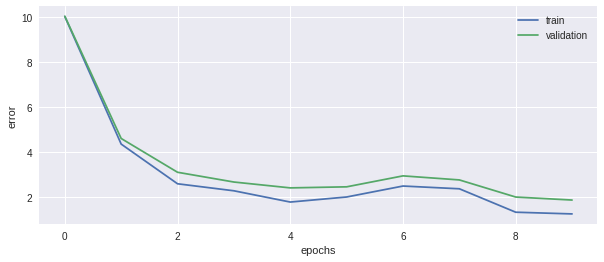


   --  Run :  10
CNN_2  Epoch: 1 [0/45056 (0%)]	Loss: 2.305643
CNN_2  Epoch: 1 [12800/45056 (28%)]	Loss: 1.849934
CNN_2  Epoch: 1 [25600/45056 (57%)]	Loss: 1.754000
CNN_2  Epoch: 1 [38400/45056 (85%)]	Loss: 0.608053

Training error: 3584/45000 (7.96%)
Validation error: 1212/15000 (8.08%)

Validation set: Average loss: 0.3065, Accuracy: 13788/15000 (91.92%)

new accuracy parameters saved 0.9192
CNN_2  Epoch: 2 [0/45056 (0%)]	Loss: 0.376205
CNN_2  Epoch: 2 [12800/45056 (28%)]	Loss: 0.148640
CNN_2  Epoch: 2 [25600/45056 (57%)]	Loss: 0.263870
CNN_2  Epoch: 2 [38400/45056 (85%)]	Loss: 0.104034

Training error: 1681/45000 (3.74%)
Validation error: 621/15000 (4.14%)

Validation set: Average loss: 0.1355, Accuracy: 14379/15000 (95.86%)

new accuracy parameters saved 0.9586
CNN_2  Epoch: 3 [0/45056 (0%)]	Loss: 0.124873
CNN_2  Epoch: 3 [12800/45056 (28%)]	Loss: 0.066142
CNN_2  Epoch: 3 [25600/45056 (57%)]	Loss: 0.117818
CNN_2  Epoch: 3 [38400/45056 (85%)]	Loss: 0.032598

Training error: 1300/45

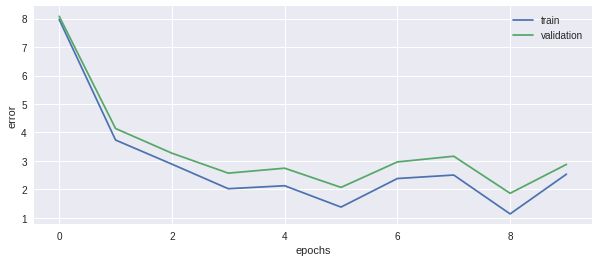

In [0]:
MultipleRun(runs,epochs,CNN_2())

### Running CNN3 


   --  Run :  1
CNN_3  Epoch: 1 [0/45056 (0%)]	Loss: 2.301777
CNN_3  Epoch: 1 [12800/45056 (28%)]	Loss: 1.837517
CNN_3  Epoch: 1 [25600/45056 (57%)]	Loss: 0.504276
CNN_3  Epoch: 1 [38400/45056 (85%)]	Loss: 0.421944

Training error: 2576/45000 (5.72%)
Validation error: 862/15000 (5.75%)

Validation set: Average loss: 0.2042, Accuracy: 14138/15000 (94.25%)

new accuracy parameters saved 0.9425333333333333
CNN_3  Epoch: 2 [0/45056 (0%)]	Loss: 0.334632
CNN_3  Epoch: 2 [12800/45056 (28%)]	Loss: 0.128344
CNN_3  Epoch: 2 [25600/45056 (57%)]	Loss: 0.100169
CNN_3  Epoch: 2 [38400/45056 (85%)]	Loss: 0.067997

Training error: 1271/45000 (2.82%)
Validation error: 475/15000 (3.17%)

Validation set: Average loss: 0.0993, Accuracy: 14525/15000 (96.83%)

new accuracy parameters saved 0.9683333333333334
CNN_3  Epoch: 3 [0/45056 (0%)]	Loss: 0.057516
CNN_3  Epoch: 3 [12800/45056 (28%)]	Loss: 0.092882
CNN_3  Epoch: 3 [25600/45056 (57%)]	Loss: 0.105346
CNN_3  Epoch: 3 [38400/45056 (85%)]	Loss: 0.110815

T

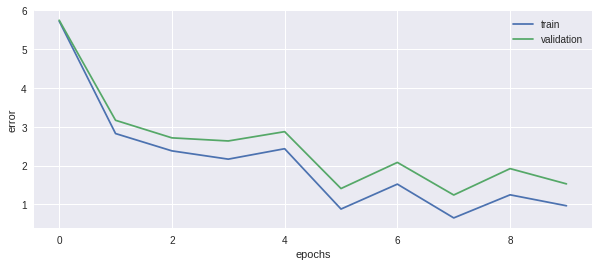


   --  Run :  2
CNN_3  Epoch: 1 [0/45056 (0%)]	Loss: 2.300948
CNN_3  Epoch: 1 [12800/45056 (28%)]	Loss: 2.036967
CNN_3  Epoch: 1 [25600/45056 (57%)]	Loss: 0.869301
CNN_3  Epoch: 1 [38400/45056 (85%)]	Loss: 0.277520

Training error: 2624/45000 (5.83%)
Validation error: 865/15000 (5.77%)

Validation set: Average loss: 0.2026, Accuracy: 14135/15000 (94.23%)

new accuracy parameters saved 0.9423333333333334
CNN_3  Epoch: 2 [0/45056 (0%)]	Loss: 0.215086
CNN_3  Epoch: 2 [12800/45056 (28%)]	Loss: 0.593657
CNN_3  Epoch: 2 [25600/45056 (57%)]	Loss: 0.173584
CNN_3  Epoch: 2 [38400/45056 (85%)]	Loss: 0.097882

Training error: 1466/45000 (3.26%)
Validation error: 542/15000 (3.61%)

Validation set: Average loss: 0.1183, Accuracy: 14458/15000 (96.39%)

new accuracy parameters saved 0.9638666666666666
CNN_3  Epoch: 3 [0/45056 (0%)]	Loss: 0.101632
CNN_3  Epoch: 3 [12800/45056 (28%)]	Loss: 0.334820
CNN_3  Epoch: 3 [25600/45056 (57%)]	Loss: 0.104426
CNN_3  Epoch: 3 [38400/45056 (85%)]	Loss: 0.037848

T

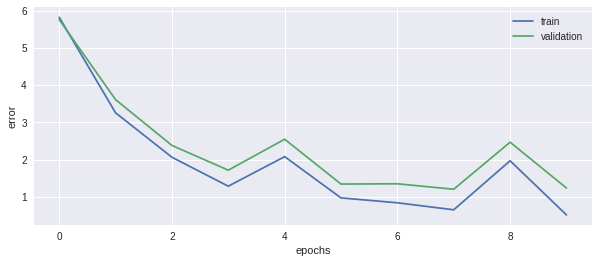


   --  Run :  3
CNN_3  Epoch: 1 [0/45056 (0%)]	Loss: 2.299459
CNN_3  Epoch: 1 [12800/45056 (28%)]	Loss: 2.117304
CNN_3  Epoch: 1 [25600/45056 (57%)]	Loss: 0.613463
CNN_3  Epoch: 1 [38400/45056 (85%)]	Loss: 0.316542

Training error: 2693/45000 (5.98%)
Validation error: 890/15000 (5.93%)

Validation set: Average loss: 0.1968, Accuracy: 14110/15000 (94.07%)

new accuracy parameters saved 0.9406666666666667
CNN_3  Epoch: 2 [0/45056 (0%)]	Loss: 0.148676
CNN_3  Epoch: 2 [12800/45056 (28%)]	Loss: 0.170159
CNN_3  Epoch: 2 [25600/45056 (57%)]	Loss: 0.087042
CNN_3  Epoch: 2 [38400/45056 (85%)]	Loss: 0.106287

Training error: 1558/45000 (3.46%)
Validation error: 528/15000 (3.52%)

Validation set: Average loss: 0.1113, Accuracy: 14472/15000 (96.48%)

new accuracy parameters saved 0.9648
CNN_3  Epoch: 3 [0/45056 (0%)]	Loss: 0.125428
CNN_3  Epoch: 3 [12800/45056 (28%)]	Loss: 0.050095
CNN_3  Epoch: 3 [25600/45056 (57%)]	Loss: 0.076305
CNN_3  Epoch: 3 [38400/45056 (85%)]	Loss: 0.040556

Training erro

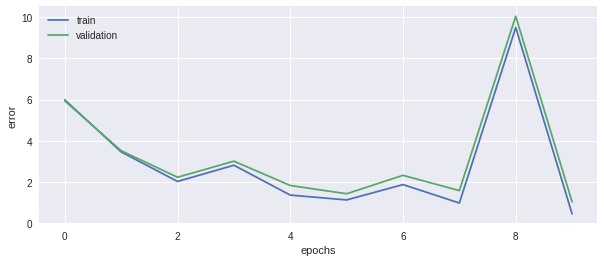


   --  Run :  4
CNN_3  Epoch: 1 [0/45056 (0%)]	Loss: 2.308805
CNN_3  Epoch: 1 [12800/45056 (28%)]	Loss: 1.835676
CNN_3  Epoch: 1 [25600/45056 (57%)]	Loss: 0.557125
CNN_3  Epoch: 1 [38400/45056 (85%)]	Loss: 0.146929

Training error: 2763/45000 (6.14%)
Validation error: 940/15000 (6.27%)

Validation set: Average loss: 0.2117, Accuracy: 14060/15000 (93.73%)

new accuracy parameters saved 0.9373333333333334
CNN_3  Epoch: 2 [0/45056 (0%)]	Loss: 0.301887
CNN_3  Epoch: 2 [12800/45056 (28%)]	Loss: 0.127501
CNN_3  Epoch: 2 [25600/45056 (57%)]	Loss: 0.138733
CNN_3  Epoch: 2 [38400/45056 (85%)]	Loss: 0.048666

Training error: 1736/45000 (3.86%)
Validation error: 650/15000 (4.33%)

Validation set: Average loss: 0.1337, Accuracy: 14350/15000 (95.67%)

new accuracy parameters saved 0.9566666666666667
CNN_3  Epoch: 3 [0/45056 (0%)]	Loss: 0.136208
CNN_3  Epoch: 3 [12800/45056 (28%)]	Loss: 0.102996
CNN_3  Epoch: 3 [25600/45056 (57%)]	Loss: 0.103506
CNN_3  Epoch: 3 [38400/45056 (85%)]	Loss: 0.099986

T

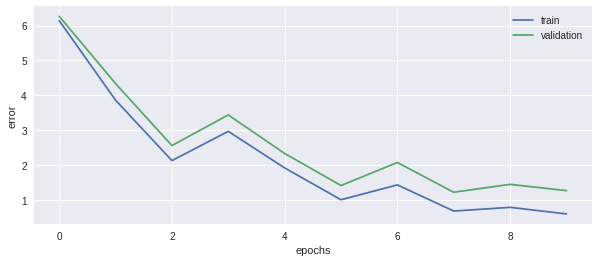


   --  Run :  5
CNN_3  Epoch: 1 [0/45056 (0%)]	Loss: 2.303156
CNN_3  Epoch: 1 [12800/45056 (28%)]	Loss: 2.087029
CNN_3  Epoch: 1 [25600/45056 (57%)]	Loss: 1.456807
CNN_3  Epoch: 1 [38400/45056 (85%)]	Loss: 0.308215

Training error: 2903/45000 (6.45%)
Validation error: 958/15000 (6.39%)

Validation set: Average loss: 0.2210, Accuracy: 14042/15000 (93.61%)

new accuracy parameters saved 0.9361333333333334
CNN_3  Epoch: 2 [0/45056 (0%)]	Loss: 0.172713
CNN_3  Epoch: 2 [12800/45056 (28%)]	Loss: 0.180575
CNN_3  Epoch: 2 [25600/45056 (57%)]	Loss: 0.119116
CNN_3  Epoch: 2 [38400/45056 (85%)]	Loss: 0.128976

Training error: 1727/45000 (3.84%)
Validation error: 629/15000 (4.19%)

Validation set: Average loss: 0.1266, Accuracy: 14371/15000 (95.81%)

new accuracy parameters saved 0.9580666666666666
CNN_3  Epoch: 3 [0/45056 (0%)]	Loss: 0.186560
CNN_3  Epoch: 3 [12800/45056 (28%)]	Loss: 0.355386
CNN_3  Epoch: 3 [25600/45056 (57%)]	Loss: 0.076134
CNN_3  Epoch: 3 [38400/45056 (85%)]	Loss: 0.040199

T

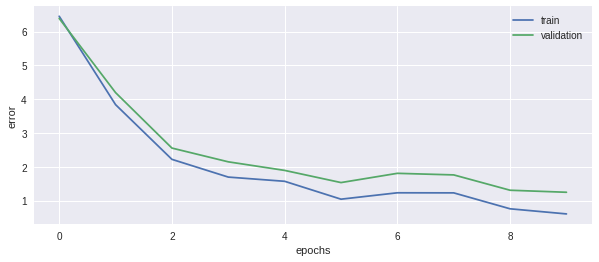


   --  Run :  6
CNN_3  Epoch: 1 [0/45056 (0%)]	Loss: 2.297245
CNN_3  Epoch: 1 [12800/45056 (28%)]	Loss: 1.855636
CNN_3  Epoch: 1 [25600/45056 (57%)]	Loss: 1.115572
CNN_3  Epoch: 1 [38400/45056 (85%)]	Loss: 0.453524

Training error: 2917/45000 (6.48%)
Validation error: 996/15000 (6.64%)

Validation set: Average loss: 0.2184, Accuracy: 14004/15000 (93.36%)

new accuracy parameters saved 0.9336
CNN_3  Epoch: 2 [0/45056 (0%)]	Loss: 0.208286
CNN_3  Epoch: 2 [12800/45056 (28%)]	Loss: 0.130662
CNN_3  Epoch: 2 [25600/45056 (57%)]	Loss: 0.104743
CNN_3  Epoch: 2 [38400/45056 (85%)]	Loss: 0.115898

Training error: 2138/45000 (4.75%)
Validation error: 755/15000 (5.03%)

Validation set: Average loss: 0.1544, Accuracy: 14245/15000 (94.97%)

new accuracy parameters saved 0.9496666666666667
CNN_3  Epoch: 3 [0/45056 (0%)]	Loss: 0.103884
CNN_3  Epoch: 3 [12800/45056 (28%)]	Loss: 0.047934
CNN_3  Epoch: 3 [25600/45056 (57%)]	Loss: 0.051135
CNN_3  Epoch: 3 [38400/45056 (85%)]	Loss: 0.038936

Training erro

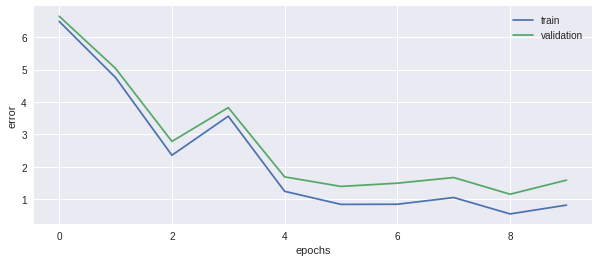


   --  Run :  7
CNN_3  Epoch: 1 [0/45056 (0%)]	Loss: 2.302903
CNN_3  Epoch: 1 [12800/45056 (28%)]	Loss: 2.013920
CNN_3  Epoch: 1 [25600/45056 (57%)]	Loss: 0.565568
CNN_3  Epoch: 1 [38400/45056 (85%)]	Loss: 0.292786

Training error: 2541/45000 (5.65%)
Validation error: 864/15000 (5.76%)

Validation set: Average loss: 0.1885, Accuracy: 14136/15000 (94.24%)

new accuracy parameters saved 0.9424
CNN_3  Epoch: 2 [0/45056 (0%)]	Loss: 0.172215
CNN_3  Epoch: 2 [12800/45056 (28%)]	Loss: 0.186282
CNN_3  Epoch: 2 [25600/45056 (57%)]	Loss: 0.149965
CNN_3  Epoch: 2 [38400/45056 (85%)]	Loss: 0.064291

Training error: 1382/45000 (3.07%)
Validation error: 513/15000 (3.42%)

Validation set: Average loss: 0.1076, Accuracy: 14487/15000 (96.58%)

new accuracy parameters saved 0.9658
CNN_3  Epoch: 3 [0/45056 (0%)]	Loss: 0.082739
CNN_3  Epoch: 3 [12800/45056 (28%)]	Loss: 0.093238
CNN_3  Epoch: 3 [25600/45056 (57%)]	Loss: 0.060208
CNN_3  Epoch: 3 [38400/45056 (85%)]	Loss: 0.109253

Training error: 1453/4500

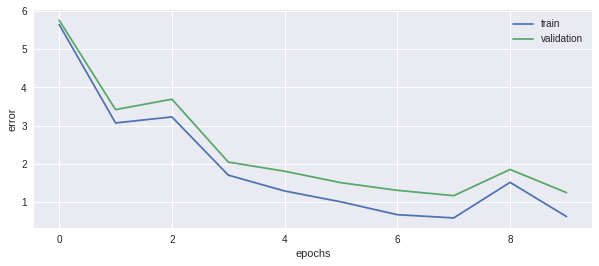


   --  Run :  8
CNN_3  Epoch: 1 [0/45056 (0%)]	Loss: 2.301390
CNN_3  Epoch: 1 [12800/45056 (28%)]	Loss: 1.954343
CNN_3  Epoch: 1 [25600/45056 (57%)]	Loss: 0.610809
CNN_3  Epoch: 1 [38400/45056 (85%)]	Loss: 0.354098

Training error: 2876/45000 (6.39%)
Validation error: 986/15000 (6.57%)

Validation set: Average loss: 0.2209, Accuracy: 14014/15000 (93.43%)

new accuracy parameters saved 0.9342666666666667
CNN_3  Epoch: 2 [0/45056 (0%)]	Loss: 0.171711
CNN_3  Epoch: 2 [12800/45056 (28%)]	Loss: 0.216337
CNN_3  Epoch: 2 [25600/45056 (57%)]	Loss: 0.066665
CNN_3  Epoch: 2 [38400/45056 (85%)]	Loss: 0.161366

Training error: 1185/45000 (2.63%)
Validation error: 469/15000 (3.13%)

Validation set: Average loss: 0.0984, Accuracy: 14531/15000 (96.87%)

new accuracy parameters saved 0.9687333333333333
CNN_3  Epoch: 3 [0/45056 (0%)]	Loss: 0.085760
CNN_3  Epoch: 3 [12800/45056 (28%)]	Loss: 0.073638
CNN_3  Epoch: 3 [25600/45056 (57%)]	Loss: 0.084071
CNN_3  Epoch: 3 [38400/45056 (85%)]	Loss: 0.147422

T

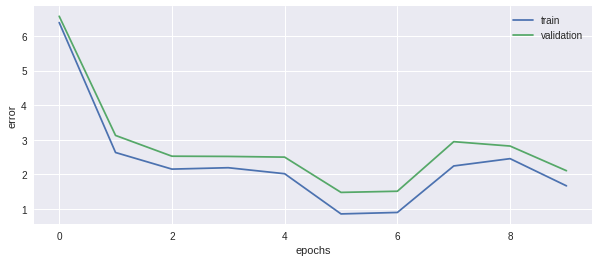


   --  Run :  9
CNN_3  Epoch: 1 [0/45056 (0%)]	Loss: 2.304939
CNN_3  Epoch: 1 [12800/45056 (28%)]	Loss: 1.608659
CNN_3  Epoch: 1 [25600/45056 (57%)]	Loss: 0.359651
CNN_3  Epoch: 1 [38400/45056 (85%)]	Loss: 0.205681

Training error: 5177/45000 (11.50%)
Validation error: 1775/15000 (11.83%)

Validation set: Average loss: 0.3502, Accuracy: 13225/15000 (88.17%)

new accuracy parameters saved 0.8816666666666667
CNN_3  Epoch: 2 [0/45056 (0%)]	Loss: 0.481350
CNN_3  Epoch: 2 [12800/45056 (28%)]	Loss: 0.241437
CNN_3  Epoch: 2 [25600/45056 (57%)]	Loss: 0.250375
CNN_3  Epoch: 2 [38400/45056 (85%)]	Loss: 0.069432

Training error: 3017/45000 (6.70%)
Validation error: 1038/15000 (6.92%)

Validation set: Average loss: 0.2160, Accuracy: 13962/15000 (93.08%)

new accuracy parameters saved 0.9308
CNN_3  Epoch: 3 [0/45056 (0%)]	Loss: 0.196385
CNN_3  Epoch: 3 [12800/45056 (28%)]	Loss: 0.072082
CNN_3  Epoch: 3 [25600/45056 (57%)]	Loss: 0.053684
CNN_3  Epoch: 3 [38400/45056 (85%)]	Loss: 0.072227

Training 

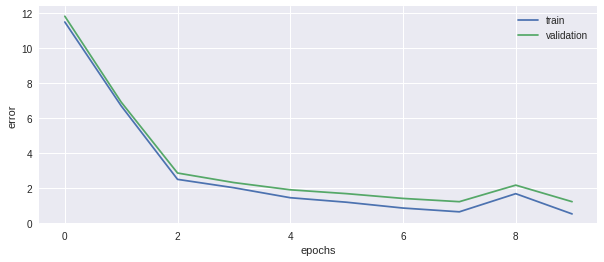


   --  Run :  10
CNN_3  Epoch: 1 [0/45056 (0%)]	Loss: 2.302372
CNN_3  Epoch: 1 [12800/45056 (28%)]	Loss: 2.178128
CNN_3  Epoch: 1 [25600/45056 (57%)]	Loss: 0.734102
CNN_3  Epoch: 1 [38400/45056 (85%)]	Loss: 0.250324

Training error: 2954/45000 (6.56%)
Validation error: 992/15000 (6.61%)

Validation set: Average loss: 0.2152, Accuracy: 14008/15000 (93.39%)

new accuracy parameters saved 0.9338666666666666
CNN_3  Epoch: 2 [0/45056 (0%)]	Loss: 0.198579
CNN_3  Epoch: 2 [12800/45056 (28%)]	Loss: 0.072917
CNN_3  Epoch: 2 [25600/45056 (57%)]	Loss: 0.175249
CNN_3  Epoch: 2 [38400/45056 (85%)]	Loss: 0.073853

Training error: 1334/45000 (2.96%)
Validation error: 478/15000 (3.19%)

Validation set: Average loss: 0.1045, Accuracy: 14522/15000 (96.81%)

new accuracy parameters saved 0.9681333333333333
CNN_3  Epoch: 3 [0/45056 (0%)]	Loss: 0.107894
CNN_3  Epoch: 3 [12800/45056 (28%)]	Loss: 0.121255
CNN_3  Epoch: 3 [25600/45056 (57%)]	Loss: 0.103541
CNN_3  Epoch: 3 [38400/45056 (85%)]	Loss: 0.073895



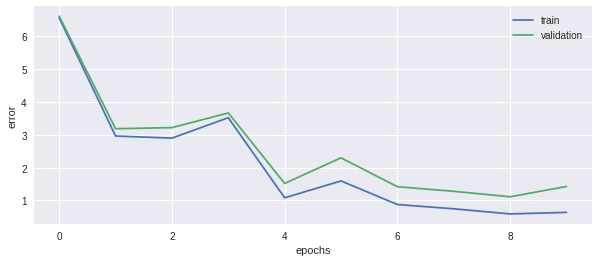

In [0]:
MultipleRun(runs,epochs,CNN_3())

#### MLP


   --  Run :  1
MLP_2L  Epoch: 1 [0/45056 (0%)]	Loss: 2.302860
MLP_2L  Epoch: 1 [12800/45056 (28%)]	Loss: 0.570843
MLP_2L  Epoch: 1 [25600/45056 (57%)]	Loss: 0.354279
MLP_2L  Epoch: 1 [38400/45056 (85%)]	Loss: 0.303558

Training error: 4547/45000 (10.10%)
Validation error: 1530/15000 (10.20%)

Validation set: Average loss: 0.3451, Accuracy: 13470/15000 (89.80%)

new accuracy parameters saved 0.898
MLP_2L  Epoch: 2 [0/45056 (0%)]	Loss: 0.196903
MLP_2L  Epoch: 2 [12800/45056 (28%)]	Loss: 0.275565
MLP_2L  Epoch: 2 [25600/45056 (57%)]	Loss: 0.279963
MLP_2L  Epoch: 2 [38400/45056 (85%)]	Loss: 0.384716

Training error: 3153/45000 (7.01%)
Validation error: 1140/15000 (7.60%)

Validation set: Average loss: 0.2623, Accuracy: 13860/15000 (92.40%)

new accuracy parameters saved 0.924
MLP_2L  Epoch: 3 [0/45056 (0%)]	Loss: 0.216535
MLP_2L  Epoch: 3 [12800/45056 (28%)]	Loss: 0.187697
MLP_2L  Epoch: 3 [25600/45056 (57%)]	Loss: 0.215225
MLP_2L  Epoch: 3 [38400/45056 (85%)]	Loss: 0.344272

Training er

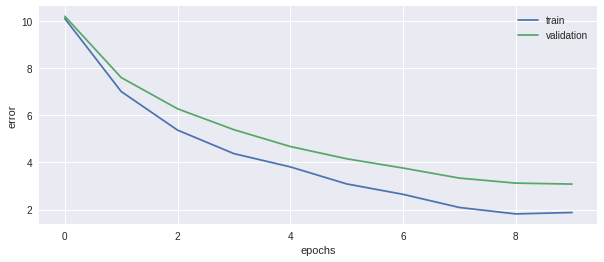


   --  Run :  2
MLP_2L  Epoch: 1 [0/45056 (0%)]	Loss: 2.303701
MLP_2L  Epoch: 1 [12800/45056 (28%)]	Loss: 0.662335
MLP_2L  Epoch: 1 [25600/45056 (57%)]	Loss: 0.343621
MLP_2L  Epoch: 1 [38400/45056 (85%)]	Loss: 0.370854

Training error: 4710/45000 (10.47%)
Validation error: 1587/15000 (10.58%)

Validation set: Average loss: 0.3496, Accuracy: 13413/15000 (89.42%)

new accuracy parameters saved 0.8942
MLP_2L  Epoch: 2 [0/45056 (0%)]	Loss: 0.317781
MLP_2L  Epoch: 2 [12800/45056 (28%)]	Loss: 0.259550
MLP_2L  Epoch: 2 [25600/45056 (57%)]	Loss: 0.303644
MLP_2L  Epoch: 2 [38400/45056 (85%)]	Loss: 0.374352

Training error: 3082/45000 (6.85%)
Validation error: 1110/15000 (7.40%)

Validation set: Average loss: 0.2626, Accuracy: 13890/15000 (92.60%)

new accuracy parameters saved 0.926
MLP_2L  Epoch: 3 [0/45056 (0%)]	Loss: 0.250574
MLP_2L  Epoch: 3 [12800/45056 (28%)]	Loss: 0.247649
MLP_2L  Epoch: 3 [25600/45056 (57%)]	Loss: 0.133032
MLP_2L  Epoch: 3 [38400/45056 (85%)]	Loss: 0.175597

Training e

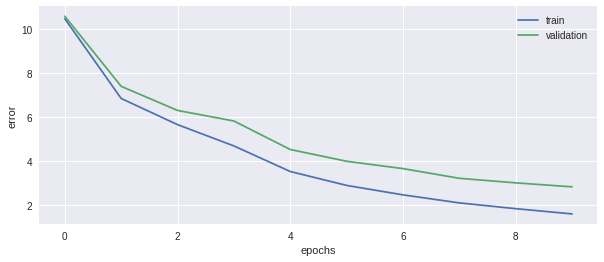


   --  Run :  3
MLP_2L  Epoch: 1 [0/45056 (0%)]	Loss: 2.295341
MLP_2L  Epoch: 1 [12800/45056 (28%)]	Loss: 0.582861
MLP_2L  Epoch: 1 [25600/45056 (57%)]	Loss: 0.457454
MLP_2L  Epoch: 1 [38400/45056 (85%)]	Loss: 0.348758

Training error: 4175/45000 (9.28%)
Validation error: 1396/15000 (9.31%)

Validation set: Average loss: 0.3315, Accuracy: 13604/15000 (90.69%)

new accuracy parameters saved 0.9069333333333334
MLP_2L  Epoch: 2 [0/45056 (0%)]	Loss: 0.266497
MLP_2L  Epoch: 2 [12800/45056 (28%)]	Loss: 0.247199
MLP_2L  Epoch: 2 [25600/45056 (57%)]	Loss: 0.288036
MLP_2L  Epoch: 2 [38400/45056 (85%)]	Loss: 0.216259

Training error: 2959/45000 (6.58%)
Validation error: 1091/15000 (7.27%)

Validation set: Average loss: 0.2496, Accuracy: 13909/15000 (92.73%)

new accuracy parameters saved 0.9272666666666667
MLP_2L  Epoch: 3 [0/45056 (0%)]	Loss: 0.282518
MLP_2L  Epoch: 3 [12800/45056 (28%)]	Loss: 0.237556
MLP_2L  Epoch: 3 [25600/45056 (57%)]	Loss: 0.122493
MLP_2L  Epoch: 3 [38400/45056 (85%)]	Los

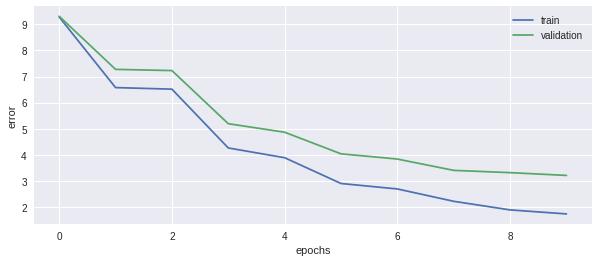


   --  Run :  4
MLP_2L  Epoch: 1 [0/45056 (0%)]	Loss: 2.302474
MLP_2L  Epoch: 1 [12800/45056 (28%)]	Loss: 0.696629
MLP_2L  Epoch: 1 [25600/45056 (57%)]	Loss: 0.375110
MLP_2L  Epoch: 1 [38400/45056 (85%)]	Loss: 0.350918

Training error: 4314/45000 (9.59%)
Validation error: 1491/15000 (9.94%)

Validation set: Average loss: 0.3507, Accuracy: 13509/15000 (90.06%)

new accuracy parameters saved 0.9006
MLP_2L  Epoch: 2 [0/45056 (0%)]	Loss: 0.452351
MLP_2L  Epoch: 2 [12800/45056 (28%)]	Loss: 0.285438
MLP_2L  Epoch: 2 [25600/45056 (57%)]	Loss: 0.388256
MLP_2L  Epoch: 2 [38400/45056 (85%)]	Loss: 0.374531

Training error: 3097/45000 (6.88%)
Validation error: 1132/15000 (7.55%)

Validation set: Average loss: 0.2553, Accuracy: 13868/15000 (92.45%)

new accuracy parameters saved 0.9245333333333333
MLP_2L  Epoch: 3 [0/45056 (0%)]	Loss: 0.189459
MLP_2L  Epoch: 3 [12800/45056 (28%)]	Loss: 0.181825
MLP_2L  Epoch: 3 [25600/45056 (57%)]	Loss: 0.186555
MLP_2L  Epoch: 3 [38400/45056 (85%)]	Loss: 0.122604


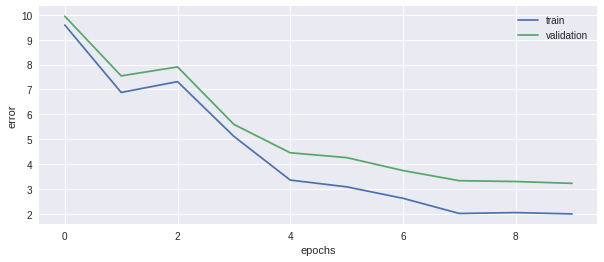


   --  Run :  5
MLP_2L  Epoch: 1 [0/45056 (0%)]	Loss: 2.300911
MLP_2L  Epoch: 1 [12800/45056 (28%)]	Loss: 0.633132
MLP_2L  Epoch: 1 [25600/45056 (57%)]	Loss: 0.364447
MLP_2L  Epoch: 1 [38400/45056 (85%)]	Loss: 0.396006

Training error: 4360/45000 (9.69%)
Validation error: 1499/15000 (9.99%)

Validation set: Average loss: 0.3403, Accuracy: 13501/15000 (90.01%)

new accuracy parameters saved 0.9000666666666667
MLP_2L  Epoch: 2 [0/45056 (0%)]	Loss: 0.238857
MLP_2L  Epoch: 2 [12800/45056 (28%)]	Loss: 0.422462
MLP_2L  Epoch: 2 [25600/45056 (57%)]	Loss: 0.246527
MLP_2L  Epoch: 2 [38400/45056 (85%)]	Loss: 0.237879

Training error: 3226/45000 (7.17%)
Validation error: 1181/15000 (7.87%)

Validation set: Average loss: 0.2680, Accuracy: 13819/15000 (92.13%)

new accuracy parameters saved 0.9212666666666667
MLP_2L  Epoch: 3 [0/45056 (0%)]	Loss: 0.187852
MLP_2L  Epoch: 3 [12800/45056 (28%)]	Loss: 0.269513
MLP_2L  Epoch: 3 [25600/45056 (57%)]	Loss: 0.234584
MLP_2L  Epoch: 3 [38400/45056 (85%)]	Los

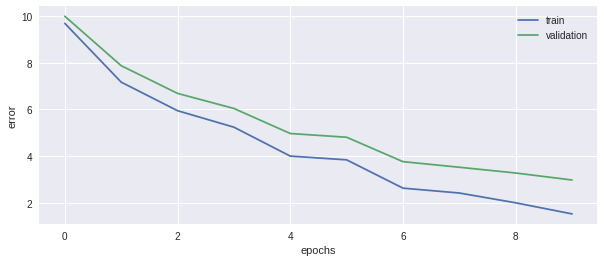


   --  Run :  6
MLP_2L  Epoch: 1 [0/45056 (0%)]	Loss: 2.307983
MLP_2L  Epoch: 1 [12800/45056 (28%)]	Loss: 0.619446
MLP_2L  Epoch: 1 [25600/45056 (57%)]	Loss: 0.335392
MLP_2L  Epoch: 1 [38400/45056 (85%)]	Loss: 0.552102

Training error: 4447/45000 (9.88%)
Validation error: 1493/15000 (9.95%)

Validation set: Average loss: 0.3529, Accuracy: 13507/15000 (90.05%)

new accuracy parameters saved 0.9004666666666666
MLP_2L  Epoch: 2 [0/45056 (0%)]	Loss: 0.272628
MLP_2L  Epoch: 2 [12800/45056 (28%)]	Loss: 0.350629
MLP_2L  Epoch: 2 [25600/45056 (57%)]	Loss: 0.284530
MLP_2L  Epoch: 2 [38400/45056 (85%)]	Loss: 0.282931

Training error: 4456/45000 (9.90%)
Validation error: 1548/15000 (10.32%)

Validation set: Average loss: 0.3290, Accuracy: 13452/15000 (89.68%)

MLP_2L  Epoch: 3 [0/45056 (0%)]	Loss: 0.354068
MLP_2L  Epoch: 3 [12800/45056 (28%)]	Loss: 0.242128
MLP_2L  Epoch: 3 [25600/45056 (57%)]	Loss: 0.147418
MLP_2L  Epoch: 3 [38400/45056 (85%)]	Loss: 0.238824

Training error: 2305/45000 (5.12%)


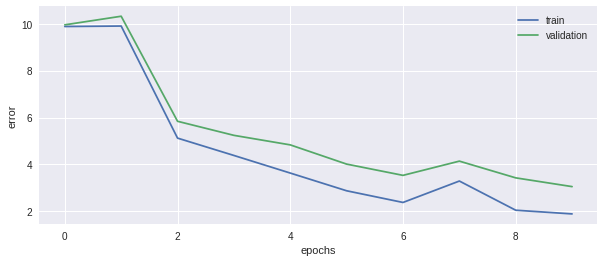


   --  Run :  7
MLP_2L  Epoch: 1 [0/45056 (0%)]	Loss: 2.307706
MLP_2L  Epoch: 1 [12800/45056 (28%)]	Loss: 0.572114
MLP_2L  Epoch: 1 [25600/45056 (57%)]	Loss: 0.339937
MLP_2L  Epoch: 1 [38400/45056 (85%)]	Loss: 0.371500

Training error: 4352/45000 (9.67%)
Validation error: 1498/15000 (9.99%)

Validation set: Average loss: 0.3479, Accuracy: 13502/15000 (90.01%)

new accuracy parameters saved 0.9001333333333333
MLP_2L  Epoch: 2 [0/45056 (0%)]	Loss: 0.373944
MLP_2L  Epoch: 2 [12800/45056 (28%)]	Loss: 0.418999
MLP_2L  Epoch: 2 [25600/45056 (57%)]	Loss: 0.289853
MLP_2L  Epoch: 2 [38400/45056 (85%)]	Loss: 0.339311

Training error: 3226/45000 (7.17%)
Validation error: 1150/15000 (7.67%)

Validation set: Average loss: 0.2622, Accuracy: 13850/15000 (92.33%)

new accuracy parameters saved 0.9233333333333333
MLP_2L  Epoch: 3 [0/45056 (0%)]	Loss: 0.269940
MLP_2L  Epoch: 3 [12800/45056 (28%)]	Loss: 0.364593
MLP_2L  Epoch: 3 [25600/45056 (57%)]	Loss: 0.171978
MLP_2L  Epoch: 3 [38400/45056 (85%)]	Los

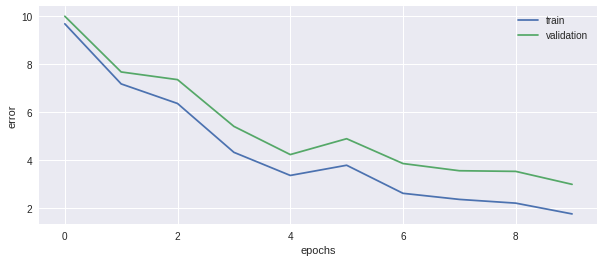


   --  Run :  8
MLP_2L  Epoch: 1 [0/45056 (0%)]	Loss: 2.303355
MLP_2L  Epoch: 1 [12800/45056 (28%)]	Loss: 0.675243
MLP_2L  Epoch: 1 [25600/45056 (57%)]	Loss: 0.344028
MLP_2L  Epoch: 1 [38400/45056 (85%)]	Loss: 0.364307

Training error: 4239/45000 (9.42%)
Validation error: 1460/15000 (9.73%)

Validation set: Average loss: 0.3356, Accuracy: 13540/15000 (90.27%)

new accuracy parameters saved 0.9026666666666666
MLP_2L  Epoch: 2 [0/45056 (0%)]	Loss: 0.278647
MLP_2L  Epoch: 2 [12800/45056 (28%)]	Loss: 0.371450
MLP_2L  Epoch: 2 [25600/45056 (57%)]	Loss: 0.282586
MLP_2L  Epoch: 2 [38400/45056 (85%)]	Loss: 0.279956

Training error: 3375/45000 (7.50%)
Validation error: 1208/15000 (8.05%)

Validation set: Average loss: 0.2731, Accuracy: 13792/15000 (91.95%)

new accuracy parameters saved 0.9194666666666667
MLP_2L  Epoch: 3 [0/45056 (0%)]	Loss: 0.267467
MLP_2L  Epoch: 3 [12800/45056 (28%)]	Loss: 0.234838
MLP_2L  Epoch: 3 [25600/45056 (57%)]	Loss: 0.199772
MLP_2L  Epoch: 3 [38400/45056 (85%)]	Los

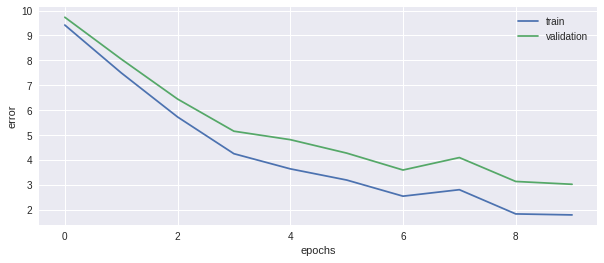


   --  Run :  9
MLP_2L  Epoch: 1 [0/45056 (0%)]	Loss: 2.298639
MLP_2L  Epoch: 1 [12800/45056 (28%)]	Loss: 0.692178
MLP_2L  Epoch: 1 [25600/45056 (57%)]	Loss: 0.622699
MLP_2L  Epoch: 1 [38400/45056 (85%)]	Loss: 0.465889

Training error: 4186/45000 (9.30%)
Validation error: 1461/15000 (9.74%)

Validation set: Average loss: 0.3390, Accuracy: 13539/15000 (90.26%)

new accuracy parameters saved 0.9026
MLP_2L  Epoch: 2 [0/45056 (0%)]	Loss: 0.356039
MLP_2L  Epoch: 2 [12800/45056 (28%)]	Loss: 0.434211
MLP_2L  Epoch: 2 [25600/45056 (57%)]	Loss: 0.179269
MLP_2L  Epoch: 2 [38400/45056 (85%)]	Loss: 0.238677

Training error: 3276/45000 (7.28%)
Validation error: 1149/15000 (7.66%)

Validation set: Average loss: 0.2612, Accuracy: 13851/15000 (92.34%)

new accuracy parameters saved 0.9234
MLP_2L  Epoch: 3 [0/45056 (0%)]	Loss: 0.253864
MLP_2L  Epoch: 3 [12800/45056 (28%)]	Loss: 0.249118
MLP_2L  Epoch: 3 [25600/45056 (57%)]	Loss: 0.179822
MLP_2L  Epoch: 3 [38400/45056 (85%)]	Loss: 0.249270

Training er

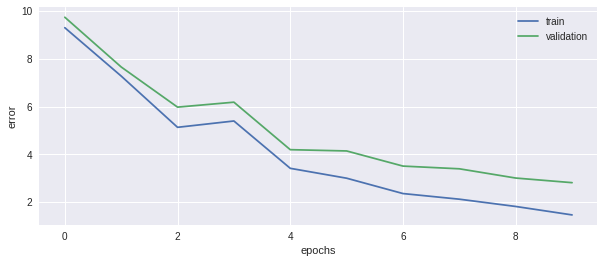


   --  Run :  10
MLP_2L  Epoch: 1 [0/45056 (0%)]	Loss: 2.304741
MLP_2L  Epoch: 1 [12800/45056 (28%)]	Loss: 0.725870
MLP_2L  Epoch: 1 [25600/45056 (57%)]	Loss: 0.348289
MLP_2L  Epoch: 1 [38400/45056 (85%)]	Loss: 0.480133

Training error: 4618/45000 (10.26%)
Validation error: 1601/15000 (10.67%)

Validation set: Average loss: 0.3578, Accuracy: 13399/15000 (89.33%)

new accuracy parameters saved 0.8932666666666667
MLP_2L  Epoch: 2 [0/45056 (0%)]	Loss: 0.261969
MLP_2L  Epoch: 2 [12800/45056 (28%)]	Loss: 0.419703
MLP_2L  Epoch: 2 [25600/45056 (57%)]	Loss: 0.376604
MLP_2L  Epoch: 2 [38400/45056 (85%)]	Loss: 0.291034

Training error: 3180/45000 (7.07%)
Validation error: 1113/15000 (7.42%)

Validation set: Average loss: 0.2643, Accuracy: 13887/15000 (92.58%)

new accuracy parameters saved 0.9258
MLP_2L  Epoch: 3 [0/45056 (0%)]	Loss: 0.174867
MLP_2L  Epoch: 3 [12800/45056 (28%)]	Loss: 0.226755
MLP_2L  Epoch: 3 [25600/45056 (57%)]	Loss: 0.152514
MLP_2L  Epoch: 3 [38400/45056 (85%)]	Loss: 0.1336

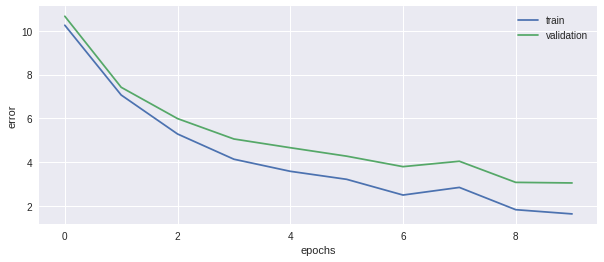

In [0]:
MultipleRun(runs,epochs,MLP_2L())


### Compairing Results

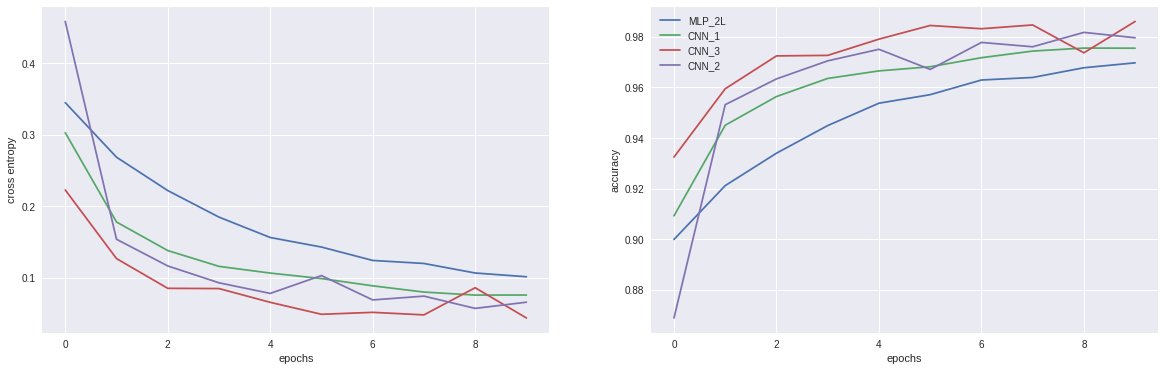

In [0]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

for filename in os.listdir(savedir):
    if filename.endswith('.pkl'):
        with open(os.path.join(savedir, filename),'rb') as fin:
            results = pickle.load(fin)
            ax1.plot(results['loss'], label = filename[:-4])
            ax1.set_ylabel('cross entropy')
            ax1.set_xlabel('epochs')
            
            ax2.plot(results['accuracy'], label = filename[:-4])
            ax2.set_ylabel('accuracy')
            ax2.set_xlabel('epochs')
            
plt.legend()

### Final comments

When looking at the aboves charts, we have to remember that it is plotted from the average of 10 runs of 10 epochs.
So what we see is really the evolution of the models during training.  For exemple: CNN2 always starts with poor results for the first epoch.

##### CNN1
As this model slightly outperforms the MLP at every epoch, we can imagine it also doing better in the long run.  However, since they end up with the same value on the last epoch, we would need a longer run to confirm that.  With half as many parameters as the MLP, it would be tempting to declare this model simply superior to the MLP, but we should not jump to hasty conclusions as we should remember from part 1 that some models with lower number of parameters also performed well, so there might be a redundent amount of neurons that don't contribute much.

Still it is really interesting that we can simply replace 400k parameters with 320 parameters and gain in performance.  It clearly shows that a single layers gets more out of the 32 feature maps then a fully connected layer.

##### CNN2 
With a second round of convolution the effect is even more pronounced and the model now clearly outperforms the MLP.  However this time we have have a convolution of 512 filters for the missing 400k parameters that make it equivalent to the MLP in number of paramters but much better in performance.

##### CNN3
Reaching 99% on test accuracy,  this model we conserve the same number of paramaters with another round of convolution thanks to more pooling. Compared to CNN2 , mostly only the architecture changed, being deeper and slightly thinner 

Not only does CNN3, CNN2 and the MLP have similar number of parameters, but they are also distributed and balanced in a similar way, where the parameters in the first fully connected hidden layer are replaced by the parameters of the convolution.

It is unknown with this experiment how much convolution depth we can add and still gain perfomance, either plateau or loose performance.    

What this experiment has shown though with all three models is how much convolution is better then a fully connected layer for image based classification.  MNIST being a relatively simple dataset, we suspect that with a more complex task the difference would be even more pronounced and we could really see the difference in capacity. 
